# Laboratorio 8 — Detección de Anomalías con Autoencoder, Isolation Forest y LOF

In [1]:
%pip install -U numpy pandas scikit-learn matplotlib tensorflow==2.*


  Using cached numpy-2.3.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    f1_score, confusion_matrix, precision_score, recall_score
)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams.update({'figure.dpi': 110})


## 1. Carga y descripción del conjunto de datos

Usaremos el dataset CoverType desde `sklearn.datasets.fetch_covtype(as_frame=True)`, que entrega ~581k observaciones, 54 características (10 numéricas continuas, 44 binarias), y la etiqueta `Cover_Type` (1..7).  
Las variables binarias corresponden a `Wilderness_Area` (4 columnas) y `Soil_Type` (40 columnas).

**Preparación pedida:** escalar solo las variables numéricas y dejar las binarias como están.

In [3]:
# Carga como DataFrame para obtener nombres de columnas
cov = fetch_covtype(as_frame=True)
X_full = cov.data.copy()
y_full = cov.target.copy()  # valores 1..7

print('Dimensiones de X:', X_full.shape)
print('Distribución de Cover_Type (1..7):')
print(y_full.value_counts().sort_index())
X_full.head()


Dimensiones de X: (581012, 54)
Distribución de Cover_Type (1..7):
Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
Name: count, dtype: int64


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Identificación de columnas numéricas vs binarias
num_expected = [
    'Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
    'Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]
if not set(num_expected).issubset(set(X_full.columns)):
    nunique = X_full.nunique()
    numeric_cols = nunique[nunique > 2].index.tolist()
    binary_cols = [c for c in X_full.columns if c not in numeric_cols]
else:
    numeric_cols = num_expected
    binary_cols = [c for c in X_full.columns if c not in numeric_cols]

print('Numéricas ({}):'.format(len(numeric_cols)), numeric_cols[:10], '...' if len(numeric_cols)>10 else '')
print('Binarias ({}):'.format(len(binary_cols)))


Numéricas (10): ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'] 
Binarias (44):


## 2. Etiquetado de normalidad/anomalía

Se asume normal cuando `Cover_Type == 2` . El resto (`!= 2`) se marca como anomalía.  
Esto se alinea con el enfoque de aprendizaje de una sola clase/detección de novedad, donde el modelo aprende solo de la clase "normal".

In [5]:
# y_bin: 0=normal (Cover_Type==2), 1=anomalia (!=2)
y_bin = (y_full != 2).astype(int)
print('Proporción de anomalías:', y_bin.mean().round(4))


Proporción de anomalías: 0.5124


## 3. División Train/Val/Test

- **Train/Val:** solo observaciones normales (Cover_Type==2). Esto evita que el modelo 'aprenda' patrones de anomalía y es la práctica recomendada en autoencoders/novelty detection.  
- **Test:** mezcla natural (normales + anómalas) para evaluar con métricas de clasificación.



In [6]:
# Partición
X_norm = X_full[y_bin == 0].reset_index(drop=True)
X_anom = X_full[y_bin == 1].reset_index(drop=True)

X_train_norm, X_val_norm = train_test_split(
    X_norm, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

TEST_MAX_NORMALS = 80000
TEST_MAX_ANOMS   = 80000
X_test_norm = X_norm.sample(min(TEST_MAX_NORMALS, len(X_norm)), random_state=RANDOM_STATE)
X_test_anom = X_anom.sample(min(TEST_MAX_ANOMS, len(X_anom)), random_state=RANDOM_STATE)
X_test = pd.concat([X_test_norm, X_test_anom], axis=0).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
y_test = np.r_[np.zeros(len(X_test_norm), dtype=int), np.ones(len(X_test_anom), dtype=int)]
y_test = pd.Series(y_test, index=pd.RangeIndex(len(y_test)))
y_test = y_test.loc[X_test.index]

print('Train(normales):', X_train_norm.shape,
      '| Val(normales):', X_val_norm.shape,
      '| Test (mixto):', X_test.shape, ' [anom%≈{:.2f}]'.format(100*y_test.mean()))


Train(normales): (226640, 54) | Val(normales): (56661, 54) | Test (mixto): (160000, 54)  [anom%≈50.00]


### 3.1 Escalamiento de variables numéricas

Se escala únicamente las columnas numéricas con `StandardScaler` (media 0, var 1).  
Las binarias se dejan como están.

In [7]:
scaler = StandardScaler()

def ajustar_transformar_dividir(train_df, val_df, test_df, num_cols, bin_cols):
    train_num = scaler.fit_transform(train_df[num_cols])
    val_num   = scaler.transform(val_df[num_cols])
    test_num  = scaler.transform(test_df[num_cols])
    def rebuild(df, num_mat):
        out = pd.DataFrame(num_mat, columns=num_cols, index=df.index)
        out[bin_cols] = df[bin_cols].reset_index(drop=True)
        return out
    Xtr = rebuild(train_df.reset_index(drop=True), train_num)
    Xva = rebuild(val_df.reset_index(drop=True),   val_num)
    Xte = rebuild(test_df.reset_index(drop=True),  test_num)
    return Xtr, Xva, Xte

X_train, X_val, X_test_scaled = ajustar_transformar_dividir(
    X_train_norm, X_val_norm, X_test, numeric_cols, binary_cols
)
X_train.shape, X_val.shape, X_test_scaled.shape


((226640, 54), (56661, 54), (160000, 54))

## 4. Funciones auxiliares: métricas y visualización

In [8]:
from typing import Tuple

def precision_en_k(y_true: np.ndarray, scores: np.ndarray, k: int) -> float:
    idx = np.argsort(scores)[::-1][:k]
    return y_true[idx].mean()

def evaluar_metricas(y_true: np.ndarray, scores: np.ndarray, threshold: float) -> dict:
    y_pred = (scores >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, scores)
    pr_auc = average_precision_score(y_true, scores)
    return {'threshold': threshold, 'F1': f1, 'Precision': prec, 'Recall': rec,
            'ROC_AUC': roc, 'PR_AUC': pr_auc, 'cm': cm, 'y_pred': y_pred}

def graficar_matriz_de_confusion(cm, title='Matriz de confusión'):
    fig = plt.figure()
    ax = plt.gca()
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel('Predicción (0=normal, 1=anómalo)')
    ax.set_ylabel('Real (0=normal, 1=anómalo)')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center')
    plt.tight_layout()
    plt.show()

def graficar_curvas_roc_pr(y_true: np.ndarray, scores: np.ndarray, title_prefix=''):
    fpr, tpr, _ = roc_curve(y_true, scores)
    fig1 = plt.figure()
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0,1],[0,1],'--', label='azar')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'{title_prefix} ROC')
    plt.legend(); plt.show()

    prec, rec, _ = precision_recall_curve(y_true, scores)
    fig2 = plt.figure()
    plt.plot(rec, prec, label='PR')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'{title_prefix} PR')
    plt.legend(); plt.show()


## 5. Autoencoder (AE)

- Arquitectura **simétrica**, activaciones ReLU y capa de salida lineal.  
- Pérdida: **MSE**.  
- **EarlyStopping** con `val_loss`.  
- Entrenamiento **solo** con `X_train` (normales); validación con `X_val` (normales).

In [9]:
AE_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except Exception as e:
    AE_AVAILABLE = False
    print('TensorFlow/Keras no disponible. Para ejecutar el Autoencoder, instale TensorFlow.')
    print('Error:', e)


In [10]:
ae_history = None
ae_model = None

if AE_AVAILABLE:
    input_dim = X_train.shape[1]
    hidden_dims = [64, 32, 16]

    inputs = keras.Input(shape=(input_dim,), name='ae_input')
    x = layers.Dense(hidden_dims[0], activation='relu')(inputs)
    x = layers.Dense(hidden_dims[1], activation='relu')(x)
    encoded = layers.Dense(hidden_dims[2], activation='relu', name='encoded')(x)
    x = layers.Dense(hidden_dims[1], activation='relu')(encoded)
    x = layers.Dense(hidden_dims[0], activation='relu')(x)
    outputs = layers.Dense(input_dim, activation='linear')(x)

    ae_model = keras.Model(inputs, outputs, name='autoencoder')
    ae_model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

    cb_early = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    ae_history = ae_model.fit(
        X_train.values, X_train.values,
        validation_data=(X_val.values, X_val.values),
        epochs=100, batch_size=512, callbacks=[cb_early], verbose=1
    )
else:
    print('Omitiendo entrenamiento de Autoencoder por falta de TensorFlow.')


Epoch 1/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0488 - val_loss: 0.0138
Epoch 2/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 3/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 4/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - val_loss: 0.0044
Epoch 5/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 6/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 11/100
443/443 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 12/100
443/443 ━━━━━━━━━━━━━━━━━━━━

In [11]:
def calcular_errores_de_reconstruccion(model, X):
    preds = model.predict(X.values, verbose=0)
    err = np.mean((preds - X.values) ** 2, axis=1)
    return err

ae_val_scores = None
ae_test_scores = None
if AE_AVAILABLE and ae_model is not None:
    ae_val_scores  = calcular_errores_de_reconstruccion(ae_model, X_val)
    ae_test_scores = calcular_errores_de_reconstruccion(ae_model, X_test_scaled)
    print('AE | PR-AUC (test):', average_precision_score(y_test, ae_test_scores))
else:
    print('AE no entrenado; no hay scores.')


AE | PR-AUC (test): 0.5017519309714956


### 5.1 Selección de umbral (AE)

Probamos dos enfoques usando **scores de reconstrucción**:

1. **Percentil** calculado sobre una validación **mixta** etiquetada.  
2. **Umbral óptimo por F1** (grid sobre percentiles 80..99.9).



In [12]:
# Construimos una validación mixta mínima SOLO para decidir umbrales (estratificada)
lab_norm = X_norm.sample(20000, random_state=RANDOM_STATE)
lab_anom = X_anom.sample(20000, random_state=RANDOM_STATE)
X_val_mixed = pd.concat([lab_norm, lab_anom]).sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
y_val_mixed = np.r_[np.zeros(len(lab_norm), dtype=int), np.ones(len(lab_anom), dtype=int)]

def aplicar_escalado(df):
    df_num = scaler.transform(df[numeric_cols])
    out = pd.DataFrame(df_num, columns=numeric_cols)
    out[binary_cols] = df[binary_cols].reset_index(drop=True)
    return out
X_val_mixed_sc = aplicar_escalado(X_val_mixed)

ae_thr_results = {}
if AE_AVAILABLE and ae_model is not None:
    ae_val_mixed_scores = calcular_errores_de_reconstruccion(ae_model, X_val_mixed_sc)
    p = 95
    thr_p95 = np.percentile(ae_val_mixed_scores, p)
    res_p = evaluar_metricas(y_val_mixed, ae_val_mixed_scores, thr_p95)
    ae_thr_results[f'percentil_{p}'] = res_p

    pct_grid = np.r_[np.linspace(80, 99, 20), np.linspace(99.1, 99.9, 9)]
    best = None
    for q in pct_grid:
        thr = np.percentile(ae_val_mixed_scores, q)
        r = evaluar_metricas(y_val_mixed, ae_val_mixed_scores, thr)
        if (best is None) or (r['F1'] > best['F1']):
            best = r
    ae_thr_results['mejor_F1_val_mixta'] = best
    print('AE (val mixta) — percentil 95:', res_p)
    print('AE (val mixta) — mejor F1:', best)
else:
    print('AE no disponible para selección de umbral.')


AE (val mixta) — percentil 95: {'threshold': 0.02127821772303609, 'F1': 0.09181818181818181, 'Precision': 0.505, 'Recall': 0.0505, 'ROC_AUC': 0.5038003575, 'PR_AUC': 0.5050870190638003, 'cm': array([[19010,   990],
       [18990,  1010]], dtype=int64), 'y_pred': array([1, 0, 1, ..., 0, 0, 0])}
AE (val mixta) — mejor F1: {'threshold': 0.0027051355829229504, 'F1': 0.2925714285714286, 'Precision': 0.512, 'Recall': 0.2048, 'ROC_AUC': 0.5038003575, 'PR_AUC': 0.5050870190638003, 'cm': array([[16096,  3904],
       [15904,  4096]], dtype=int64), 'y_pred': array([1, 0, 1, ..., 0, 1, 0])}


AE — Evaluación en TEST con umbral seleccionado: {'threshold': 0.0027051355829229504, 'F1': 0.2910206258890469, 'Precision': 0.5039100985221675, 'Recall': 0.2045875, 'ROC_AUC': 0.5019617325000001, 'PR_AUC': 0.5017519309714956, 'cm': array([[63887, 16113],
       [63633, 16367]], dtype=int64), 'y_pred': array([1, 0, 0, ..., 0, 1, 0])}


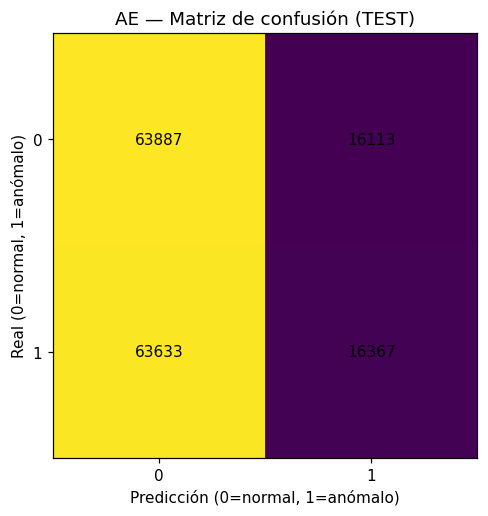

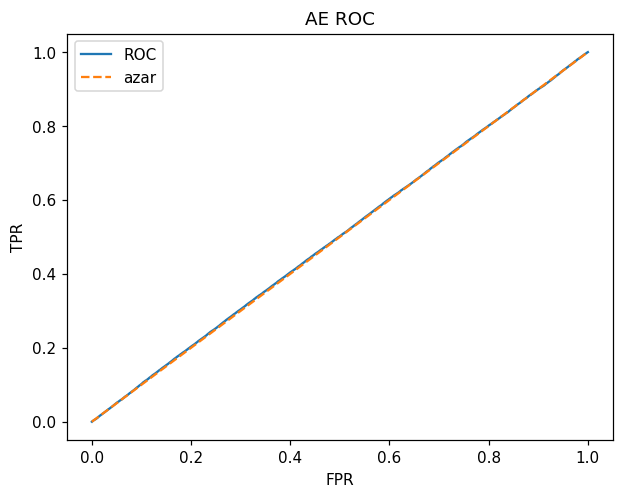

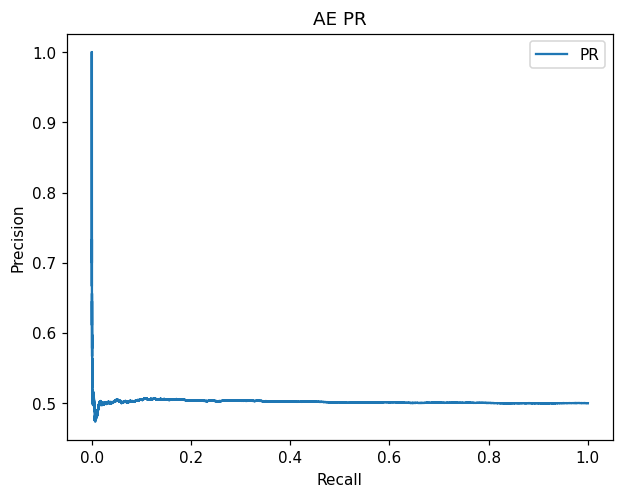

In [13]:
ae_test_eval = None
if AE_AVAILABLE and (ae_test_scores is not None) and (len(ae_thr_results)>0):
    best_key = max(ae_thr_results.keys(), key=lambda k: ae_thr_results[k]['F1'])
    thr_best = ae_thr_results[best_key]['threshold']
    ae_test_eval = evaluar_metricas(y_test.values, ae_test_scores, thr_best)
    print('AE — Evaluación en TEST con umbral seleccionado:', ae_test_eval)
    graficar_matriz_de_confusion(ae_test_eval['cm'], title='AE — Matriz de confusión (TEST)')
    graficar_curvas_roc_pr(y_test.values, ae_test_scores, title_prefix='AE')


## 6. Isolation Forest (IF)

Entrenado solo con **normales** (`X_train`). Se puede ajustar `n_estimators`, `max_samples`, `max_features` y `contamination`.  
Para seleccionar umbral, se sigue la misma idea usando una **validación mixta** con etiquetas.

IF — mejor F1 (val mixta): {'threshold': 0.4330356171569011, 'F1': 0.2857857142857143, 'Precision': 0.500125, 'Recall': 0.20005, 'ROC_AUC': 0.49971605874999997, 'PR_AUC': 0.500354453858684, 'cm': array([[16001,  3999],
       [15999,  4001]], dtype=int64), 'y_pred': array([0, 0, 1, ..., 0, 0, 0])}
IF — Evaluación en TEST: {'threshold': 0.4330356171569011, 'F1': 0.28645671113167753, 'Precision': 0.497173570568066, 'Recall': 0.2011875, 'ROC_AUC': 0.5002940467968751, 'PR_AUC': 0.49934400817888436, 'cm': array([[63722, 16278],
       [63905, 16095]], dtype=int64), 'y_pred': array([1, 0, 0, ..., 0, 0, 0])}


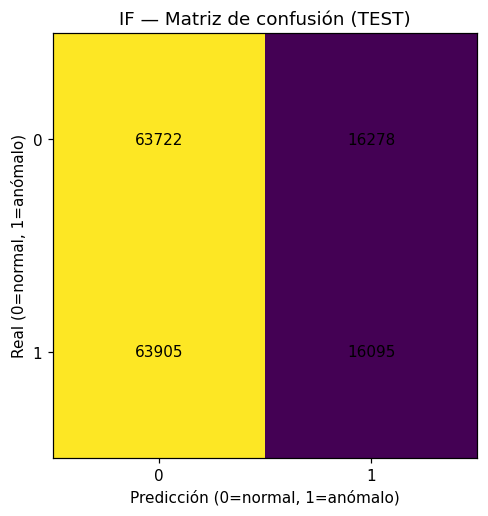

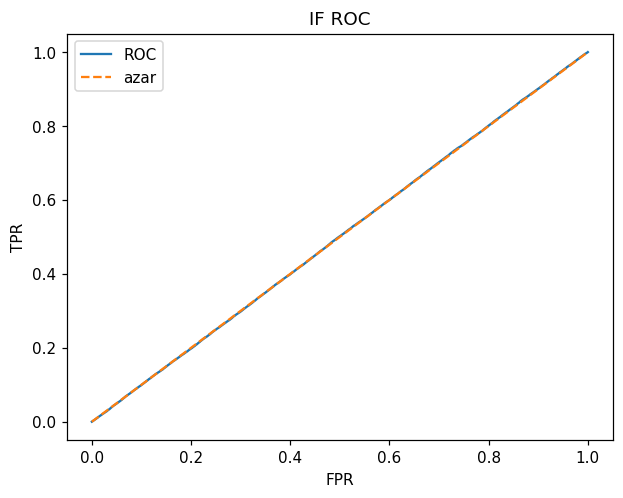

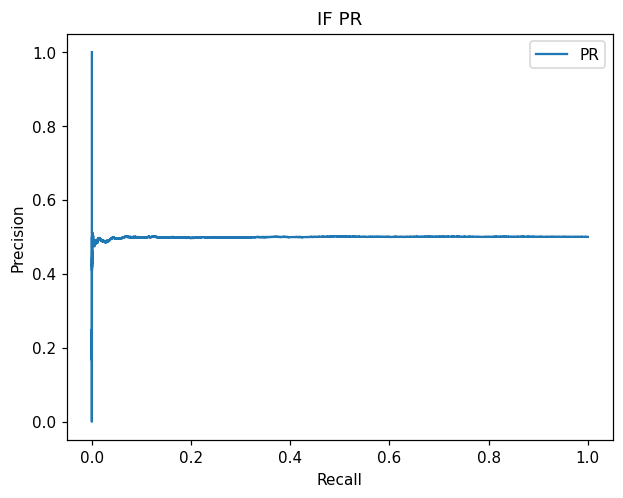

In [14]:
if_model = IsolationForest(
    n_estimators=200, max_samples='auto', contamination='auto',
    random_state=RANDOM_STATE, n_jobs=-1
)
if_model.fit(X_train)

if_val_scores  = -if_model.score_samples(X_val)
if_test_scores = -if_model.score_samples(X_test_scaled)

if_val_mixed_scores = -if_model.score_samples(X_val_mixed_sc)
best_if = None
for q in np.r_[np.linspace(80, 99, 20), np.linspace(99.1, 99.9, 9)]:
    thr = np.percentile(if_val_mixed_scores, q)
    r = evaluar_metricas(y_val_mixed, if_val_mixed_scores, thr)
    if (best_if is None) or (r['F1'] > best_if['F1']):
        best_if = r
if_test_eval = evaluar_metricas(y_test.values, if_test_scores, best_if['threshold'])
print('IF — mejor F1 (val mixta):', best_if)
print('IF — Evaluación en TEST:', if_test_eval)
graficar_matriz_de_confusion(if_test_eval['cm'], title='IF — Matriz de confusión (TEST)')
graficar_curvas_roc_pr(y_test.values, if_test_scores, title_prefix='IF')


## 7. Local Outlier Factor (LOF, novelty=True)

Con `novelty=True`, LOF aprende la "normalidad" y permite puntuar nuevas muestras con `score_samples`.  
Recomendado ajustar `n_neighbors` y `leaf_size` según tamaño/recursos.

c:\Users\Eduar\OneDrive\Documentos\DATA SCIENCE\Lab8_DS\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Eduar\OneDrive\Documentos\DATA SCIENCE\Lab8_DS\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\Eduar\OneDrive\Documentos\DATA SCIENCE\Lab8_DS\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF — mejor F1 (val mixta): {'threshold': 1.474255736329092, 'F1': 0.28314285714285714, 'Precision': 0.4955, 'Recall': 0.1982, 'ROC_AUC': 0.49952316750000003, 'PR_AUC': 0.5013382167595388, 'cm': array([[15964,  4036],
       [16036,  3964]], dtype=int64), 'y_pred': array([1, 0, 1, ..., 0, 0, 0])}
LOF — Evaluación en TEST: {'threshold': 1.474255736329092, 'F1': 0.28785674114674925, 'Precision': 0.5035133193841541, 'Recall': 0.2015375, 'ROC_AUC': 0.502813122109375, 'PR_AUC': 0.5031607063803168, 'cm': array([[64102, 15898],
       [63877, 16123]], dtype=int64), 'y_pred': array([1, 0, 0, ..., 0, 1, 0])}


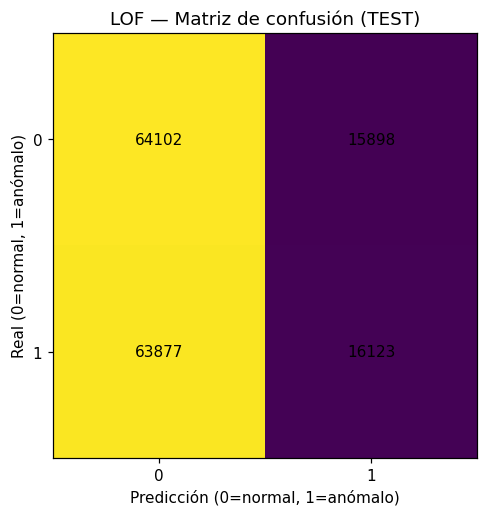

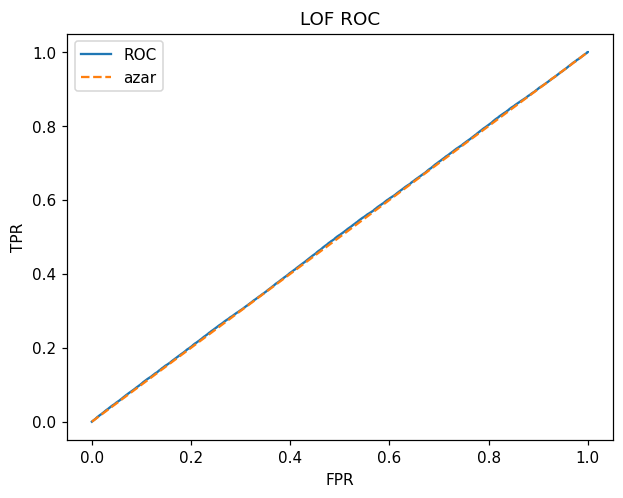

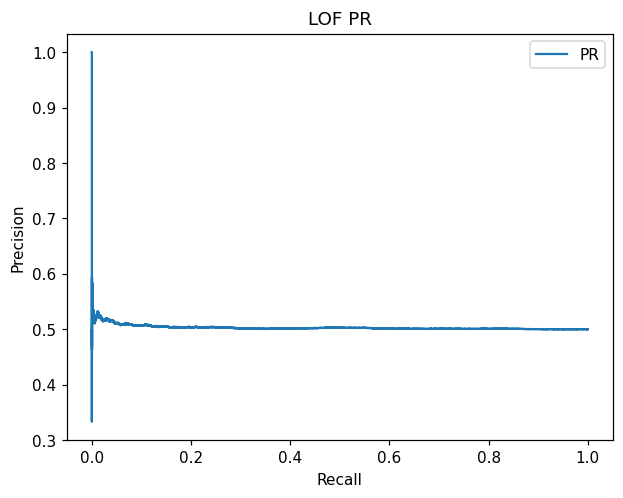

In [15]:
lof_model = LocalOutlierFactor(n_neighbors=35, novelty=True, leaf_size=40, n_jobs=-1)
lof_model.fit(X_train)

lof_val_scores  = -lof_model.score_samples(X_val)
lof_test_scores = -lof_model.score_samples(X_test_scaled)
lof_val_mixed_scores = -lof_model.score_samples(X_val_mixed_sc)

best_lof = None
for q in np.r_[np.linspace(80, 99, 20), np.linspace(99.1, 99.9, 9)]:
    thr = np.percentile(lof_val_mixed_scores, q)
    r = evaluar_metricas(y_val_mixed, lof_val_mixed_scores, thr)
    if (best_lof is None) or (r['F1'] > best_lof['F1']):
        best_lof = r
lof_test_eval = evaluar_metricas(y_test.values, lof_test_scores, best_lof['threshold'])
print('LOF — mejor F1 (val mixta):', best_lof)
print('LOF — Evaluación en TEST:', lof_test_eval)
graficar_matriz_de_confusion(lof_test_eval['cm'], title='LOF — Matriz de confusión (TEST)')
graficar_curvas_roc_pr(y_test.values, lof_test_scores, title_prefix='LOF')


## 8. Ranking y Precision@k

In [16]:
def resumir_precision_en_k(name, y_true, scores, ks=(100, 500, 1000, 5000)):
    out = []
    for k in ks:
        k = min(k, len(scores))
        out.append((name, k, precision_en_k(np.asarray(y_true), np.asarray(scores), k)))
    return pd.DataFrame(out, columns=['modelo','k','Precision@k'])

rows = []
if 'ae_test_scores' in globals() and (ae_test_scores is not None):
    rows.append(resumir_precision_en_k('AE', y_test.values, ae_test_scores))
rows.append(resumir_precision_en_k('IF', y_test.values, if_test_scores))
rows.append(resumir_precision_en_k('LOF', y_test.values, lof_test_scores))
precision_k_df = pd.concat(rows, axis=0)
precision_k_df


,modelo,k,Precision@k
0,AE,100,0.5400
1,AE,500,0.5080
2,AE,1000,0.4790
3,AE,5000,0.5004
0,IF,100,0.4300
1,IF,500,0.4860
2,IF,1000,0.4840
3,IF,5000,0.4880
0,LOF,100,0.5500
1,LOF,500,0.5280


## 9. Comparación final de modelos

In [17]:
summary_rows = []
if 'ae_test_eval' in globals() and (ae_test_eval is not None):
    summary_rows.append(['AE', ae_test_eval['ROC_AUC'], ae_test_eval['PR_AUC'], ae_test_eval['F1'], ae_test_eval['Precision'], ae_test_eval['Recall']])
summary_rows.append(['IF', if_test_eval['ROC_AUC'], if_test_eval['PR_AUC'], if_test_eval['F1'], if_test_eval['Precision'], if_test_eval['Recall']])
summary_rows.append(['LOF', lof_test_eval['ROC_AUC'], lof_test_eval['PR_AUC'], lof_test_eval['F1'], lof_test_eval['Precision'], lof_test_eval['Recall']])
summary_df = pd.DataFrame(summary_rows, columns=['Modelo','ROC_AUC','PR_AUC','F1','Precision','Recall'])
summary_df.sort_values(by='PR_AUC', ascending=False, inplace=True)
summary_df


,Modelo,ROC_AUC,PR_AUC,F1,Precision,Recall
2,LOF,0.502813,0.503161,0.287857,0.503513,0.201538
0,AE,0.501962,0.501752,0.291021,0.503910,0.204588
1,IF,0.500294,0.499344,0.286457,0.497174,0.201187
